In [1]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import psutil
from numpy import mean, where, sqrt

from sklearn.metrics import mean_squared_error
from sklearn import ensemble
from sklearn.model_selection import learning_curve, GridSearchCV

from tools import append_list_as_row

In [2]:
import glob
glob.glob("../TimeSeriesModeling/703891_32.97_-96.74_*.csv")

['../TimeSeriesModeling\\703891_32.97_-96.74_2010.csv',
 '../TimeSeriesModeling\\703891_32.97_-96.74_2011.csv',
 '../TimeSeriesModeling\\703891_32.97_-96.74_2012.csv',
 '../TimeSeriesModeling\\703891_32.97_-96.74_2013.csv',
 '../TimeSeriesModeling\\703891_32.97_-96.74_2014.csv',
 '../TimeSeriesModeling\\703891_32.97_-96.74_2015.csv',
 '../TimeSeriesModeling\\703891_32.97_-96.74_2016.csv',
 '../TimeSeriesModeling\\703891_32.97_-96.74_2017.csv',
 '../TimeSeriesModeling\\703891_32.97_-96.74_2018.csv']

In [3]:
import time

def time_it():
    return  pd.to_datetime(time.time(),unit = 's')
def memory()->str:
    return print('used: {}% free: {:.2f}GB'.format(psutil.virtual_memory().percent, float(psutil.virtual_memory().free)/1024**3))#@ 
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H %M')

In [5]:
start = time_it()
start_memory = float(psutil.virtual_memory().free)/1024**3

all_data = pd.DataFrame()
for f in tqdm(glob.glob("../TimeSeriesModeling/703891_32.97_-96.74_*.csv")):
    df = pd.read_csv(f, header = 2, engine = 'c',  parse_dates = [['Year', 'Month', 'Day', 'Hour', 'Minute']], index_col=0, date_parser=parse)
    all_data = all_data.append(df)
    
end_memory = float(psutil.virtual_memory().free)/1024**3
end = time_it()
loop_time = end - start
loop_memory = start_memory - end_memory

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.48it/s]


In [8]:
start = time_it()
start_memory = float(psutil.virtual_memory().free)/1024**3

df_anotherway = pd.concat([pd.read_csv(f, header = 2, engine = 'c', parse_dates = [['Year', 'Month', 'Day', 'Hour', 'Minute']], 
                                       index_col=0, date_parser=parse) for f in glob.glob("../TimeSeriesModeling/703891_32.97_-96.74_*.csv")])

end_memory = float(psutil.virtual_memory().free)/1024**3
end = time_it()
list_comprehension = end - start
list_comprehension_memory = start_memory - end_memory

In [19]:
'%d MB' % (round(loop_memory,2)* 1024)

'81 MB'

In [20]:
pd.DataFrame({'Looping':{'Nanoseconds': loop_time.nanoseconds, 'Microseconds': loop_time.microseconds
                        ,'Seconds': loop_time.seconds, 'Memory': '%d MB' % (loop_memory* 1024)},
              'Vectorization':{'Nanoseconds': list_comprehension.nanoseconds, 'Microseconds': list_comprehension.microseconds
                        ,'Seconds': list_comprehension.seconds, 'Memory': '%d MB' % (list_comprehension_memory* 1024)}})

,Looping,Vectorization
Nanoseconds,553,567
Microseconds,86538,699294
Seconds,6,4
Memory,79 MB,63 MB


In [4]:
all_data.index.name = 'timestamp'

In [5]:
all_data.tail()

,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Solar Zenith Angle,Surface Albedo,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure
timestamp,,,,,,,,,,,,,,,,
2018-12-31 21:30:00,0,0,0,0,0,0,7,-14.9,139.29,0.14,4.9,0.6,7.0,50.11,-6.2,1013.0
2018-12-31 22:00:00,0,0,0,0,0,0,7,-15.1,145.55,0.14,4.7,0.6,8.0,49.73,-6.3,1014.0
2018-12-31 22:30:00,0,0,0,0,0,0,7,-15.1,151.75,0.14,4.6,0.6,9.0,49.73,-6.3,1014.0
2018-12-31 23:00:00,0,0,0,0,0,0,7,-15.1,157.77,0.14,4.5,0.6,10.0,49.57,-6.3,1014.0
2018-12-31 23:30:00,0,0,0,0,0,0,4,-15.1,163.39,0.14,4.5,0.6,11.0,49.57,-6.3,1014.0


In [6]:
# DHI, DNI and Solar Angle have a linear derrivation with GHI. The clear sky variables are also related to the GHI if the sky is clear which is a lookahead bias
all_data.drop(['DHI','DNI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI','Solar Zenith Angle'], axis = 1,inplace = True)

In [7]:
all_data.isnull().sum(), all_data.dtypes

(GHI                   0
 Cloud Type            0
 Dew Point             0
 Surface Albedo        0
 Wind Speed            0
 Precipitable Water    0
 Wind Direction        0
 Relative Humidity     0
 Temperature           0
 Pressure              0
 dtype: int64,
 GHI                     int64
 Cloud Type              int64
 Dew Point             float64
 Surface Albedo        float64
 Wind Speed            float64
 Precipitable Water    float64
 Wind Direction        float64
 Relative Humidity     float64
 Temperature           float64
 Pressure              float64
 dtype: object)

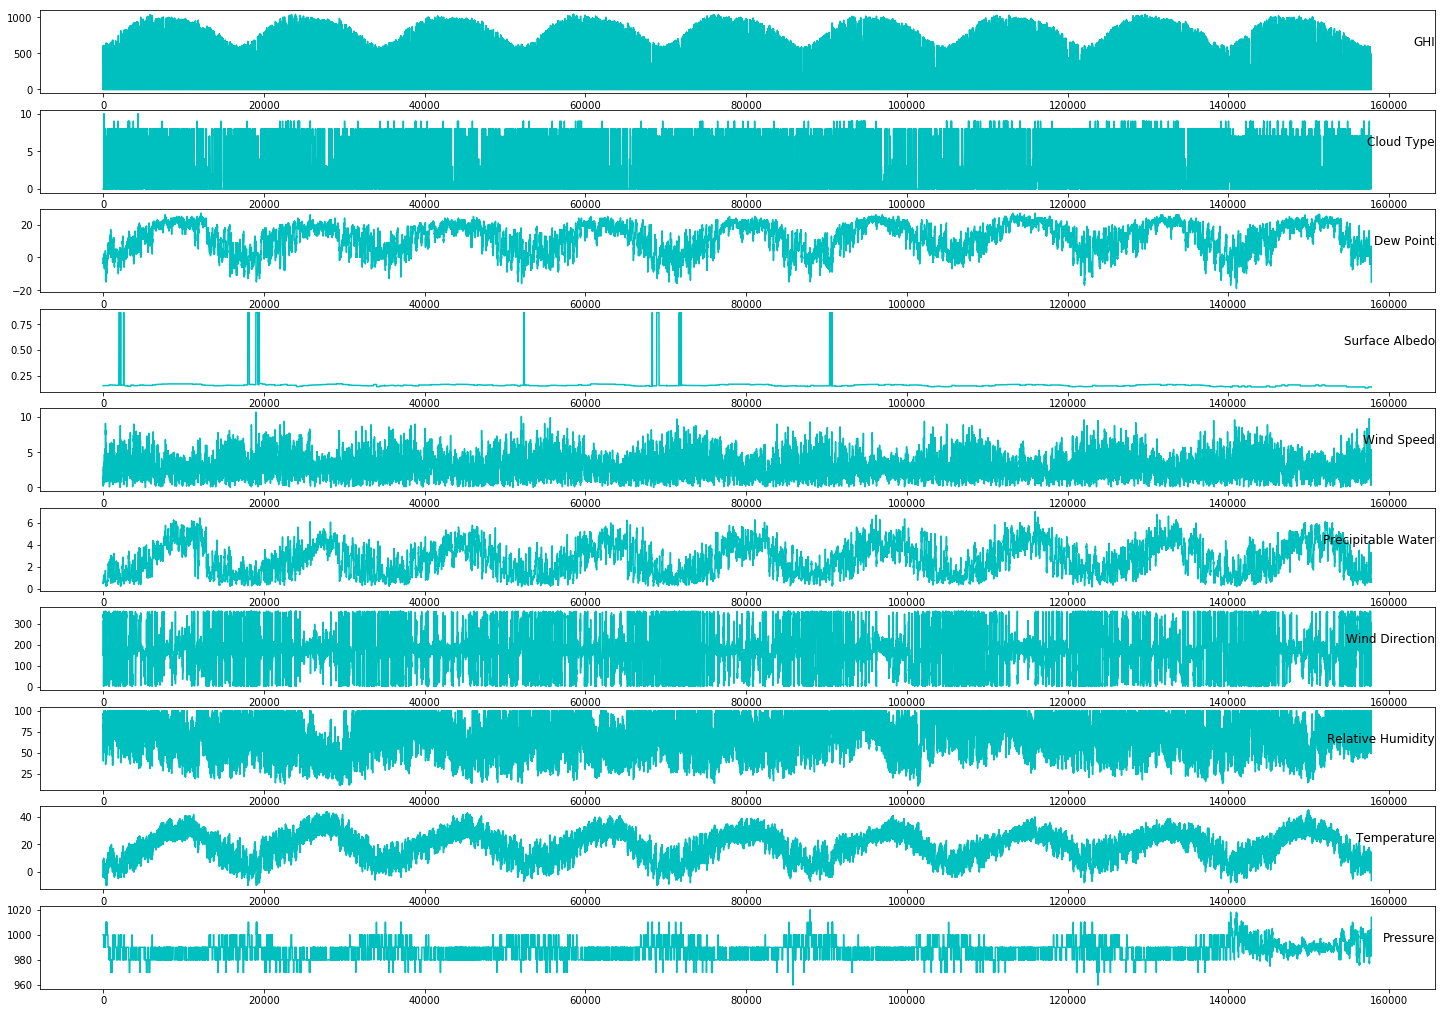

In [9]:
from matplotlib import pyplot

values = all_data.values
# specify columns to plot
groups = [x for x in range(0, len(all_data.columns))]
i = 1
# plot each column
pyplot.figure(figsize=(25,18))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group], 'c')
    pyplot.title(all_data.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show();

In [10]:
all_data['Cloud Type'].value_counts()

0     75798
7     18691
1     15336
3     14120
8     11425
4     10900
6      6625
2      3698
9      1181
10        2
Name: Cloud Type, dtype: int64

In [12]:
all_data = all_data.astype('float32')
all_data.dtypes

GHI                   float32
Cloud Type            float32
Dew Point             float32
Surface Albedo        float32
Wind Speed            float32
Precipitable Water    float32
Wind Direction        float32
Relative Humidity     float32
Temperature           float32
Pressure              float32
dtype: object

In [11]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary") 

In [12]:
for i in tqdm(all_data.columns):
    adf_test(all_data[i],str(i))
    print('\t')

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Augmented Dickey-Fuller Test: GHI


 10%|████████▏                                                                         | 1/10 [02:54<26:06, 174.10s/it]

ADF test statistic         -23.886236
p-value                      0.000000
# lags used                 76.000000
# observations          157699.000000
critical value (1%)         -3.430391
critical value (5%)         -2.861558
critical value (10%)        -2.566780
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
	
Augmented Dickey-Fuller Test: Cloud Type


 20%|████████████████▍                                                                 | 2/10 [06:22<24:35, 184.45s/it]

ADF test statistic         -35.596537
p-value                      0.000000
# lags used                 44.000000
# observations          157731.000000
critical value (1%)         -3.430391
critical value (5%)         -2.861558
critical value (10%)        -2.566780
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
	
Augmented Dickey-Fuller Test: Dew Point


 30%|████████████████████████▌                                                         | 3/10 [09:38<21:55, 187.90s/it]

ADF test statistic     -1.477719e+01
p-value                 2.274628e-27
# lags used             7.600000e+01
# observations          1.576990e+05
critical value (1%)    -3.430391e+00
critical value (5%)    -2.861558e+00
critical value (10%)   -2.566780e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
	
Augmented Dickey-Fuller Test: Surface Albedo


 40%|████████████████████████████████▊                                                 | 4/10 [13:01<19:14, 192.36s/it]

ADF test statistic         -22.381356
p-value                      0.000000
# lags used                 48.000000
# observations          157727.000000
critical value (1%)         -3.430391
critical value (5%)         -2.861558
critical value (10%)        -2.566780
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
	
Augmented Dickey-Fuller Test: Wind Speed


 50%|█████████████████████████████████████████                                         | 5/10 [15:51<15:28, 185.77s/it]

ADF test statistic         -33.852167
p-value                      0.000000
# lags used                 76.000000
# observations          157699.000000
critical value (1%)         -3.430391
critical value (5%)         -2.861558
critical value (10%)        -2.566780
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
	
Augmented Dickey-Fuller Test: Precipitable Water


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:44<12:07, 181.93s/it]

ADF test statistic     -1.560705e+01
p-value                 1.799252e-28
# lags used             7.400000e+01
# observations          1.577010e+05
critical value (1%)    -3.430391e+00
critical value (5%)    -2.861558e+00
critical value (10%)   -2.566780e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
	
Augmented Dickey-Fuller Test: Wind Direction


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [22:11<09:28, 189.45s/it]

ADF test statistic         -34.514404
p-value                      0.000000
# lags used                 76.000000
# observations          157699.000000
critical value (1%)         -3.430391
critical value (5%)         -2.861558
critical value (10%)        -2.566780
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
	
Augmented Dickey-Fuller Test: Relative Humidity


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [25:53<06:38, 199.27s/it]

ADF test statistic         -22.453462
p-value                      0.000000
# lags used                 76.000000
# observations          157699.000000
critical value (1%)         -3.430391
critical value (5%)         -2.861558
critical value (10%)        -2.566780
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
	
Augmented Dickey-Fuller Test: Temperature


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [29:33<03:25, 205.34s/it]

ADF test statistic     -1.055521e+01
p-value                 7.985037e-19
# lags used             7.600000e+01
# observations          1.576990e+05
critical value (1%)    -3.430391e+00
critical value (5%)    -2.861558e+00
critical value (10%)   -2.566780e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
	
Augmented Dickey-Fuller Test: Pressure


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [32:48<00:00, 196.84s/it]

ADF test statistic         -27.665615
p-value                      0.000000
# lags used                 75.000000
# observations          157700.000000
critical value (1%)         -3.430391
critical value (5%)         -2.861558
critical value (10%)        -2.566780
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
	


In [13]:
all_data['y'] = all_data.GHI.shift(-1) # Using t obs to predict GHI at t+1
all_data.tail(30)

,GHI,Cloud Type,Dew Point,Surface Albedo,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure,y
timestamp,,,,,,,,,,,
2018-12-31 09:00:00,183.0,7.0,3.9,0.14,5.2,0.7,232.0,83.879997,6.4,986.0,239.0
2018-12-31 09:30:00,239.0,7.0,3.9,0.14,5.1,0.6,232.0,76.750000,7.7,986.0,344.0
2018-12-31 10:00:00,344.0,7.0,3.9,0.14,5.0,0.6,232.0,70.959999,8.9,986.0,407.0
2018-12-31 10:30:00,407.0,7.0,3.9,0.14,5.0,0.6,235.0,65.480003,10.1,986.0,439.0
2018-12-31 11:00:00,439.0,7.0,3.5,0.14,5.0,0.6,238.0,58.619999,11.3,985.0,459.0
2018-12-31 11:30:00,459.0,7.0,3.5,0.14,4.9,0.7,239.0,55.250000,12.2,985.0,480.0
2018-12-31 12:00:00,480.0,7.0,3.4,0.14,4.8,0.7,239.0,52.209999,13.0,984.0,473.0
2018-12-31 12:30:00,473.0,7.0,3.4,0.14,4.7,0.8,239.0,50.540001,13.5,984.0,494.0
2018-12-31 13:00:00,494.0,7.0,3.8,0.14,4.6,0.8,239.0,50.169998,14.0,984.0,453.0


In [14]:
# all_data['Solar Zenith Angle'] = all_data['Solar Zenith Angle'].diff(1)
all_data.dropna(axis = 0, inplace =True)

In [16]:
all_data.head(), print('\n'),all_data.tail()

(                     GHI  Cloud Type  Dew Point  Surface Albedo  Wind Speed  \
 timestamp                                                                     
 2010-01-01 00:00:00  0.0         0.0       -3.0           0.153         2.9   
 2010-01-01 00:30:00  0.0         0.0       -3.0           0.153         2.7   
 2010-01-01 01:00:00  0.0         0.0       -3.0           0.153         2.5   
 2010-01-01 01:30:00  0.0         0.0       -3.0           0.153         2.4   
 2010-01-01 02:00:00  0.0         0.0       -3.0           0.153         2.4   
 
                      Precipitable Water  Wind Direction  Relative Humidity  \
 timestamp                                                                    
 2010-01-01 00:00:00               0.597      338.399994          92.660004   
 2010-01-01 00:30:00               0.553      338.399994          92.680000   
 2010-01-01 01:00:00               0.510      334.600006          96.029999   
 2010-01-01 01:30:00               0.490   

In [17]:
#linear statitics measure
all_data.corr()[['GHI', 'y']]

,GHI,y
GHI,1.000000,0.972271
Cloud Type,-0.210411,-0.203677
Dew Point,0.091423,0.092658
Surface Albedo,-0.014835,-0.014824
Wind Speed,0.206646,0.215740
Precipitable Water,0.090265,0.086972
Wind Direction,0.053884,0.060952
Relative Humidity,-0.668160,-0.629694
Temperature,0.476912,0.452969
Pressure,-0.064816,-0.042841


In [18]:
break_point = 365 * 24 * 2 * 7 # Days * Hours/Day * 30Minutes/hour * Years
train = all_data.iloc[:break_point]
test = all_data.iloc[break_point:]

# Forecast Modeling

In [66]:
average = pd.Series(mean(all_data.GHI), all_data.index)
rmse_base = sqrt(mean_squared_error(y_true = all_data.GHI, y_pred = average))

print(f'GHI Average Model: {mean(all_data.GHI):.3f}')
print(f'GHI AVERAGE Model RMSE: {rmse_base:.3f}')


GHI Average Model: 205.314
GHI AVERAGE Model RMSE: 292.467


In [20]:
append_list_as_row('rmse_results.csv', ['Average Model', rmse_base])

## Univariate Models

In [21]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

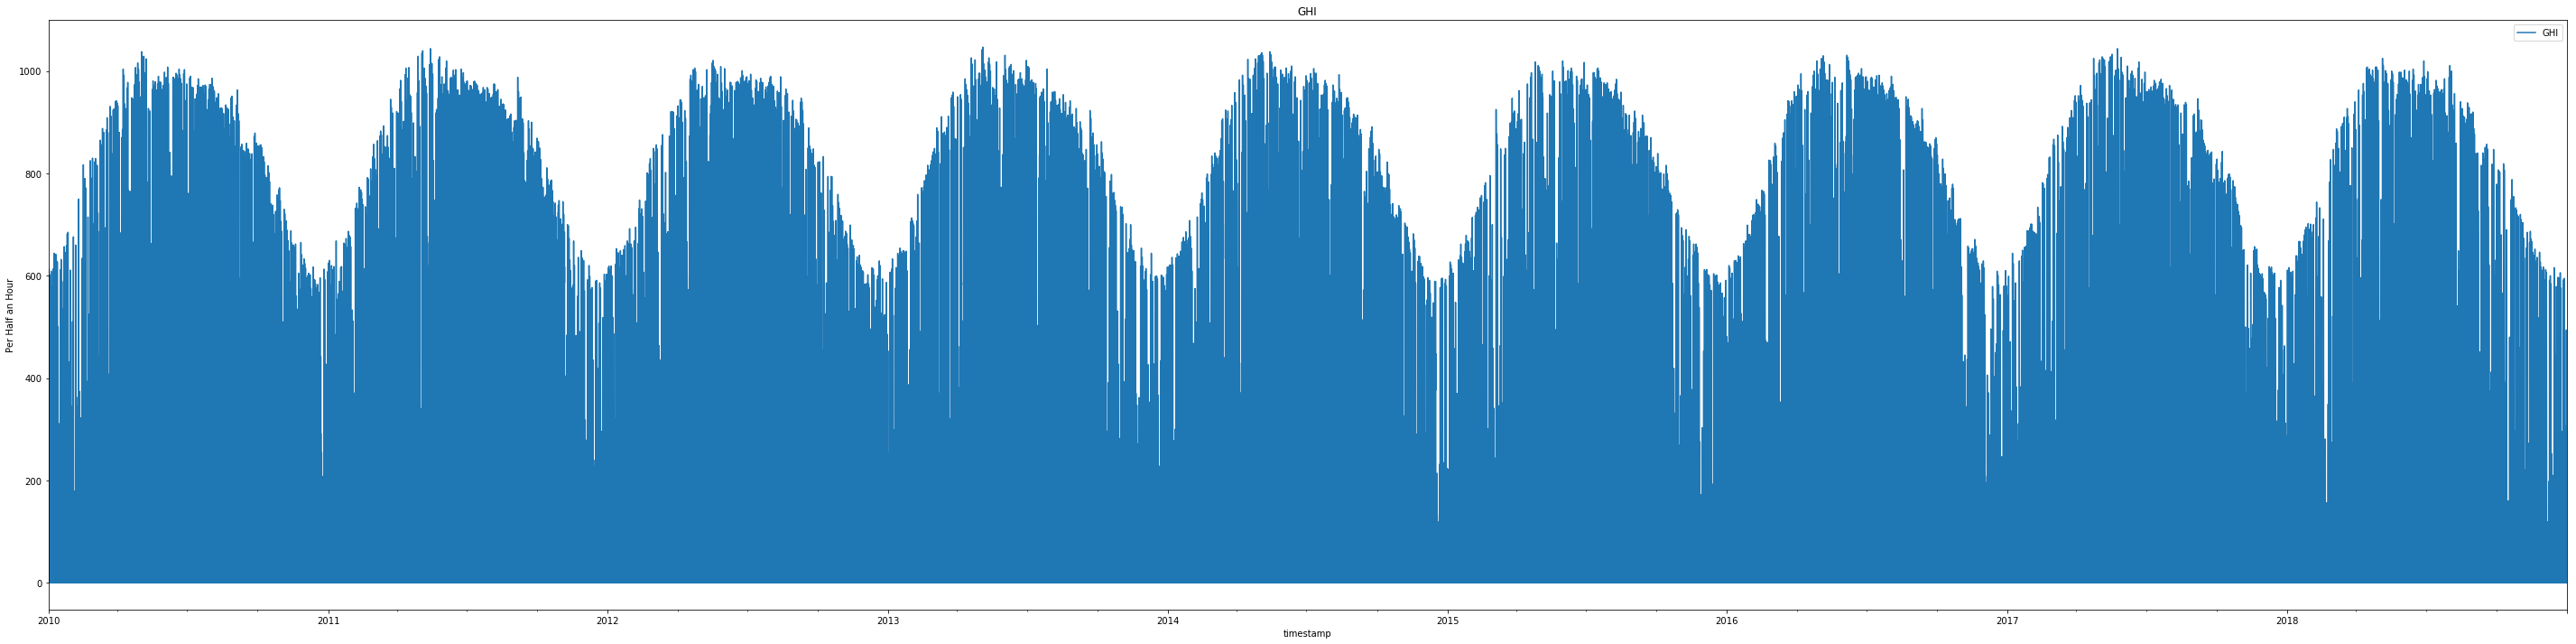

In [22]:
title = 'GHI'
ylabel='Per Half an Hour'


ax = all_data.GHI.plot(legend = True, figsize=(50,12),title=title, kind = 'line')
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=ylabel);

In [28]:
auto_arima(all_data['GHI'],error_action='ignore',seasonal=True, n_jobs=-1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               157775
Model:               SARIMAX(4, 1, 2)   Log Likelihood             -871908.277
Date:                Thu, 04 Jun 2020   AIC                        1743832.554
Time:                        11:18:29   BIC                        1743912.306
Sample:                             0   HQIC                       1743856.271
                             - 157775                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.015      0.008      0.994      -0.030       0.030
ar.L1          1.9863      0.001   1444.354      0.000       1.984       1.989
ar.L2         -1.0011      0.002   -424.713      0.000      -1.006      -0.996
ar.L3         -0.1579      0.002    -75.502      0.000      -0.162      -0.154
ar.L4          0.1183      0.001     93.836      0.000       0.116       0.121
ma.L1         -1.8692      0.001  -2093.814      0.000      -1.871      -1.867
ma.L2          0.9560      0.001   1065.949      0.000       0.954       0.958
sigma2      3694.9951      4.566    809.230      0.000    3686.046    3703.944
===================================================================================
Ljung-Box (Q):                    19023.54   Jarque-Bera (JB):           3294965.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
sarimax_model = SARIMAX(train['GHI'],exog=train['Temperature'],order=(4,1,2),seasonal_order=(0,0,0,365*24*2),enforce_invertibility=False)
results = sarimax_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    GHI   No. Observations:               122640
Model:               SARIMAX(4, 1, 2)   Log Likelihood             -677806.818
Date:                Thu, 04 Jun 2020   AIC                        1355629.635
Time:                        11:26:54   BIC                        1355707.371
Sample:                    01-01-2010   HQIC                       1355653.012
                         - 12-29-2016                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature    30.3152      0.337     89.963      0.000      29.655      30.976
ar.L1          -0.4768      0.009    -55.188      0.000      -0.494      -0.460
ar.L2           0.6031      0.008     71.139      0.000       0.586       0.620
ar.L3           0.1729      0.002     75.374      0.000       0.168       0.177
ar.L4           0.0783      0.002     38.630      0.000       0.074       0.082
ma.L1           0.5227      0.008     62.012      0.000       0.506       0.539
ma.L2          -0.4485      0.008    -52.860      0.000      -0.465      -0.432
sigma2       3739.0208      5.132    728.517      0.000    3728.962    3749.080
===================================================================================
Ljung-Box (Q):                     8073.88   Jarque-Bera (JB):           2603889.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['Temperature']]  # requires two brackets to yield a shape of (35134, 1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(4,1,2)(0,0,0,48) Predictions')

In [93]:
forecast_data = pd.DataFrame(predictions)
forecast_data[forecast_data < 0] = 0
forecast_data.head(10)

,"SARIMAX(4,1,2)(0,0,0,48) Predictions"
2016-12-30 00:00:00,0.000000
2016-12-30 00:30:00,6.688128
2016-12-30 01:00:00,6.816888
2016-12-30 01:30:00,13.927650
2016-12-30 02:00:00,11.939239
2016-12-30 02:30:00,17.860776
2016-12-30 03:00:00,15.077342
2016-12-30 03:30:00,20.188528
2016-12-30 04:00:00,16.940746
2016-12-30 04:30:00,21.554131


In [65]:
rmse_sarimax = sqrt(mean_squared_error(y_true = test['GHI'], y_pred = forecast_data['SARIMAX(4,1,2)(0,0,0,48) Predictions']))
print(f'GHI SARIMAX RMSE: {rmse_sarimax:.3f}')

GHI SARIMAX RMSE: 400.978


In [52]:
append_list_as_row('rmse_results.csv', ['SARIMAX Model', rmse_sarimax])

In [54]:
from statsmodels.tsa.api import VAR, DynamicVAR
VAR_variables = ['GHI', 'Cloud Type', 'Wind Speed', 'Relative Humidity', 'Temperature']
VAR_train, VAR_test = train[VAR_variables], test[VAR_variables]
print(VAR_train.shape, VAR_test.shape)

(122640, 5) (35135, 5)


In [56]:
#Care should be taken when using the AIC as it tends to choose large numbers of lags. Instead, for VAR models, we prefer to use the BIC
VAR_model = VAR(VAR_train)
for i in tqdm([x for x in range(1,24*2*2)]):
    VAR_results = VAR_model.fit(i)
    print('Order =', i)
    print('AIC: ', VAR_results.aic)
    print('BIC: ', VAR_results.bic)
    print()

In [57]:
VAR_model.endog_names

['GHI', 'Cloud Type', 'Wind Speed', 'Relative Humidity', 'Temperature']

In [58]:
VAR_results = VAR_model.fit(55)
VAR_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Jun, 2020
Time:                     13:07:25
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    4.67982
Nobs:                     122585.    HQIC:                   4.60334
Log likelihood:      -1.14846e+06    FPE:                    96.5867
AIC:                      4.57044    Det(Omega_mle):         95.5066
--------------------------------------------------------------------
Results for equation GHI
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        12.532664         1.240074           10.106           0.000
L1.GHI                        0.791960         0.002901          272.966           0.000
L1.Cloud Type                -

In [59]:
lag_order = VAR_results.k_ar
lag_order

55

In [60]:
frcast_test = VAR_results.forecast(y=VAR_train.values[-lag_order:], steps=len(VAR_test))
frcast_test

array([[ -1.03882874,   6.75710841,   1.45947607,  67.72878987,
          4.07096084],
       [ -1.82500659,   6.36837758,   1.43641625,  69.5496337 ,
          3.69498047],
       [ -1.24990566,   6.16557799,   1.47981333,  69.12711487,
          3.81062466],
       ...,
       [207.31547825,   2.3282564 ,   3.01985856,  70.96658531,
         18.05364829],
       [207.31547825,   2.3282564 ,   3.01985856,  70.96658531,
         18.05364829],
       [207.31547825,   2.3282564 ,   3.01985856,  70.96658531,
         18.05364829]])

In [94]:
forecast_data['VAR(55)'] = frcast_test[:,0]

In [95]:
forecast_data[forecast_data['VAR(55)'] < 0 ] = 0
forecast_data.head(20)

,"SARIMAX(4,1,2)(0,0,0,48) Predictions",VAR(55)
2016-12-30 00:00:00,0.000000,0.000000
2016-12-30 00:30:00,0.000000,0.000000
2016-12-30 01:00:00,0.000000,0.000000
2016-12-30 01:30:00,0.000000,0.000000
2016-12-30 02:00:00,0.000000,0.000000
2016-12-30 02:30:00,0.000000,0.000000
2016-12-30 03:00:00,0.000000,0.000000
2016-12-30 03:30:00,0.000000,0.000000
2016-12-30 04:00:00,0.000000,0.000000
2016-12-30 04:30:00,0.000000,0.000000


No necessary inversion required since our data was stationary and was not differenced.

In [64]:
RMSE_VAR_GHI = sqrt(mean_squared_error(y_true = test['GHI'], y_pred = forecast_data['VAR(55)']))
print(f'GHI VAR(55) RMSE: {RMSE_VAR_GHI:.3f}')

GHI VAR(55) RMSE: 283.661


In [68]:
append_list_as_row('rmse_results.csv', ['VAR(55) Model', RMSE_VAR_GHI])

In [76]:
from statsmodels.tsa.ar_model import AR,ARResults
AR_model = AR(train['GHI'])
AR5fit = AR_model.fit(maxlag=55,method='mle',maxiter = 100, solver = 'cg')
print(f'Lag: {AR5fit.k_ar}')
print(f'Coefficients:\n{AR5fit.params}')

Optimization terminated successfully.
         Current function value: 5.403694
         Iterations: 4
         Function evaluations: 9
         Gradient evaluations: 9
Lag: 55
Coefficients:
const      7.484758
L1.GHI     0.850583
L2.GHI     0.075622
L3.GHI     0.023310
L4.GHI    -0.014080
L5.GHI    -0.013786
L6.GHI    -0.013710
L7.GHI    -0.001178
L8.GHI    -0.019572
L9.GHI    -0.009440
L10.GHI    0.004213
L11.GHI   -0.005434
L12.GHI   -0.003177
L13.GHI    0.003171
L14.GHI   -0.005792
L15.GHI    0.000841
L16.GHI   -0.007894
L17.GHI    0.003536
L18.GHI    0.001643
L19.GHI    0.003627
L20.GHI    0.004749
L21.GHI    0.004880
L22.GHI    0.001892
L23.GHI    0.000698
L24.GHI   -0.000468
L25.GHI   -0.000716
L26.GHI   -0.001607
L27.GHI   -0.003089
L28.GHI   -0.005308
L29.GHI   -0.007406
L30.GHI   -0.004617
L31.GHI   -0.003901
L32.GHI   -0.001079
L33.GHI    0.000627
L34.GHI    0.000177
L35.GHI    0.001555
L36.GHI    0.004449
L37.GHI   -0.000084
L38.GHI    0.003044
L39.GHI   -0.006122
L40.GHI  

In [96]:
forecast_data['AR(55)'] = AR5fit.predict(start=start, end=end, dynamic=False)
forecast_data[forecast_data['AR(55)'] < 0 ] = 0

In [97]:
RMSE_AR_GHI = sqrt(mean_squared_error(y_true = test['GHI'], y_pred = forecast_data['AR(55)']))
print(f'GHI AR(55) RMSE: {RMSE_AR_GHI:.3f}')

GHI AR(55) RMSE: 284.664


In [99]:
append_list_as_row('rmse_results.csv', ['AR(55) Model', RMSE_AR_GHI])
forecast_data['Test_Sample'] = test['GHI']
forecast_data.to_csv('linear_TS_modeling.csv')

In [103]:
all_data.to_csv('aggregate_data.csv')

## Machine Learning (Supervised Learning)

In [111]:
X_train, y_train = train.drop(['GHI', 'y'], axis = 1), train['y']
X_test, y_test = test.drop(['GHI', 'y'], axis = 1), test['y']

In [126]:
params = {'n_estimators': 1000, 'random_state': 42, 'criterion': 'mse', 'max_leaf_nodes': 6}
gbm_model = ensemble.GradientBoostingRegressor(**params)
gbm_model.fit(X_train, y_train)

190.10047211373595

In [133]:
predictions_data = pd.DataFrame(index = test.index)
predictions_data['Basic GBM'] = gbm_model.predict(X_test)
predictions_data[predictions_data['Basic GBM'] < 0] = 0

predictions_data.head()

,Basic GBM
timestamp,
2016-12-30 00:00:00,0.000000
2016-12-30 00:30:00,1.259028
2016-12-30 01:00:00,3.367058
2016-12-30 01:30:00,0.000000
2016-12-30 02:00:00,0.000000


In [134]:
rmse_gbm = sqrt(mean_squared_error(y_true = y_test, y_pred = predictions_data['Basic GBM']))
rmse_gbm

189.6060951266128

In [135]:
append_list_as_row('rmse_results.csv', ['Basic GBM', rmse_gbm])

In [141]:
feature_importance = pd.DataFrame()
feature_importance['Variables'] = X_train.columns
feature_importance['Importance'] = gbm_model.feature_importances_
feature_importance.to_csv('feature_importance.csv')

# feature_importance values in descending order
feature_importance.sort_values(by='Importance', ascending=False)

,Variables,Importance
6,Relative Humidity,0.550324
7,Temperature,0.220233
3,Wind Speed,0.056060
5,Wind Direction,0.038280
0,Cloud Type,0.029496
2,Surface Albedo,0.029451
8,Pressure,0.027595
1,Dew Point,0.026738
4,Precipitable Water,0.021824


In [8]:
# reload cleaned data
aggregate_data = pd.read_csv('aggregate_data.csv', index_col = 0)
break_point = 365 * 24 * 2 * 7 # Days * Hours/Day * 30Minutes/hour * Years
train = aggregate_data.iloc[:break_point]
test = aggregate_data.iloc[break_point:]
X_train, y_train = train.drop(['GHI', 'y'], axis = 1), train['y']
X_test, y_test = test.drop(['GHI', 'y'], axis = 1), test['y']

params = {'n_estimators': 10000, 'random_state': 42, 'criterion': 'mse', 'max_leaf_nodes': 6, 'learning_rate': 0.001}
GBM_model = ensemble.GradientBoostingRegressor(**params)
GBM_model.fit(X_train, y_train)

pred_test = where(GBM_model.predict(X_test) < 0 , 0 , GBM_model.predict(X_test))

rmse_GBM = sqrt(mean_squared_error(y_true = y_test, y_pred = pred_test))
rmse_GBM

189.20749610443002

In [18]:
append_list_as_row('rmse_results.csv', ['10K GBM', rmse_GBM])

In [142]:
len(train)/ len(X_train.columns)

13626.666666666666

In [16]:
aggregate_data = pd.read_csv('aggregate_data.csv', index_col = 0)
feature_importance = pd.read_csv('feature_importance.csv', index_col = 0)
break_point = 365 * 24 * 2 * 7 # Days * Hours/Day * 30Minutes/hour * Years
train = aggregate_data.iloc[:break_point]
test = aggregate_data.iloc[break_point:]
X_train, y_train = train.drop(['GHI', 'y'], axis = 1), train['y']
X_test, y_test = test.drop(['GHI', 'y'], axis = 1), test['y']

# Grid Search on Important features
X_train_grid = X_train[feature_importance['Variables'][feature_importance.Importance > 0.03]]
X_test_grid = X_test[feature_importance['Variables'][feature_importance.Importance > 0.03]]

In [ ]:
# create a dictionary of hyper-parameters to optimize
parameters = {'n_estimators':  [1000, 5000, 13626],'loss': ['ls', 'lad', 'quantile'],'alpha': [0.1, 0.9],'criterion': ['mse', 'mae'], 
  'max_leaf_nodes':[4, 12, 20], 
  'learning_rate': [0.001, 0.01, 0.1], 
  'min_samples_split':  [0.0001, 0.1, 0.5]}
grid_search = GridSearchCV(estimator = ensemble.GradientBoostingRegressor(max_features = 'auto', subsample =0.8, random_state=42), scoring = 'neg_root_mean_squared_error',param_grid = parameters, cv=7,  n_jobs=-1)
grid_search = grid_search.fit(X_train_grid, y_train)
# decreased train size for faster results. This is one way to get results faster if runing short on time
best_parameters = grid_search.best_params_ 
best_accuracy = grid_search.best_score_

In [ ]:
GB_tuned = ensemble.GradientBoostingRegressor(**best_parameters,max_features = 'auto', subsample =0.8, random_state=42)
rmse_tuned_gbm = sqrt(mean_squared_error(y_true = y_test, y_pred = GB_tuned.predict(X_test)))
append_list_as_row('rmse_results.csv', ['Grid Tuned GBM', rmse_tuned_gbm])

In [ ]:
import PySimpleGUI as sg
import time


param_tuning = pd.DataFrame(columns=["# Trees", "Loss Function", "alpha",'Criterion', "Learning Rate",
                                "Max Leaf Nodes", "Min Split","MSE-Train","MSE-Test", "Loss-Train",'Loss-Test'])
i = 0
   
for n_estimators in [1000, 13626]:
    for loss in ['ls', 'lad', 'quantile']:
        for alpha in [0.1, 0.9]:
            for criterion in ['mse', 'mae']:
                    for learning_rate in [0.001, 0.1]:
                        for max_leaf_nodes in [4, 20]:
                                for min_samples_split in [0.0001, 0.1]:
                                    sg.one_line_progress_meter('GridSearch Iterations progress', i+1, 2*3*2*2*2*2*2, '-key-')
                                    time.sleep(0.5)
                                    params = {'n_estimators': n_estimators,'loss': loss,'alpha': alpha,'criterion': criterion, 
                                      'max_features':'auto','max_leaf_nodes':max_leaf_nodes, 
                                      'learning_rate': learning_rate, 
                                      'min_samples_split': min_samples_split,
                                      'subsample':0.8, 'random_state':42}
                                    model = ensemble.GradientBoostingRegressor(**params)
                                    model.fit(X_train_grid, y_train)
                                    pred_train = where(model.predict(X_train_grid) < 0, 0, model.predict(X_train_grid))
                                    pred_test = where(model.predict(X_test_grid) < 0 , 0 , model.predict(X_test_grid))
                                    param_tuning.loc[len(param_tuning)]=[n_estimators,loss ,alpha ,criterion,learning_rate ,
                                                   max_leaf_nodes, min_samples_split,
                                                   sqrt(mean_squared_error(y_true = y_train, y_pred = pred_train)),
                                                   sqrt(mean_squared_error(y_true = y_test, y_pred = pred_test)),
                                                   model.loss_(y_train,pred_train),
                                                   model.loss_(y_test,pred_test)]

In [ ]:
param_tuning.to_csv('GBModel_tuning_eval.csv', header = True, index = None)

# Deep Learning

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM

In [270]:
aggregate_data = pd.read_csv('aggregate_data.csv', index_col = 0)
feature_importance = pd.read_csv('feature_importance.csv', index_col = 0)
break_point = 365 * 24 * 2 * 7 # Days * Hours/Day * 30Minutes/hour * Years
aggregate_data = aggregate_data.astype('float32')
train = aggregate_data.iloc[:break_point]
test = aggregate_data.iloc[break_point:]

train = train.drop(['GHI'], axis = 1)
test = test.drop(['GHI'], axis = 1)

train = train.values
test = test.values


In [271]:
train.shape

(122640, 10)

In [272]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor


scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [273]:
X_train, y_train = scaled_train[:,:-1], scaled_train[:,-1]
X_test, y_test = scaled_test[:,:-1], scaled_test[:,-1]

In [274]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((122640, 9), (35135, 9), (122640,), (35135,))

In [275]:
# reshape input to be 3D [samples, timesteps, features] generalized 3D for multistep forecasting; here its just 1 timestep
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

(122640, 1, 9) (35135, 1, 9)


In [204]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units = 1))
model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100)               44000     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 44,101
Trainable params: 44,101
Non-trainable params: 0
_________________________________________________________________


In [205]:
# fit network
early_stopping = EarlyStopping(patience = 5)
history = model.fit(X_train, y_train, epochs=20, batch_size=48, 
                    validation_data=(X_test, y_test), callbacks = [early_stopping])

Train on 122640 samples, validate on 35135 samples
Epoch 1/20
122640/122640 [==============================] - 23s 188us/step - loss: 0.0411 - val_loss: 0.0350
Epoch 2/20
122640/122640 [==============================] - 20s 166us/step - loss: 0.0388 - val_loss: 0.0346
Epoch 3/20
122640/122640 [==============================] - 19s 154us/step - loss: 0.0379 - val_loss: 0.0344
Epoch 4/20
122640/122640 [==============================] - 20s 166us/step - loss: 0.0370 - val_loss: 0.0353
Epoch 5/20
122640/122640 [==============================] - 29s 236us/step - loss: 0.0363 - val_loss: 0.0350
Epoch 6/20
122640/122640 [==============================] - 22s 177us/step - loss: 0.0357 - val_loss: 0.0353
Epoch 7/20
122640/122640 [==============================] - 21s 172us/step - loss: 0.0349 - val_loss: 0.0361
Epoch 8/20
122640/122640 [==============================] - 20s 165us/step - loss: 0.0340 - val_loss: 0.0362


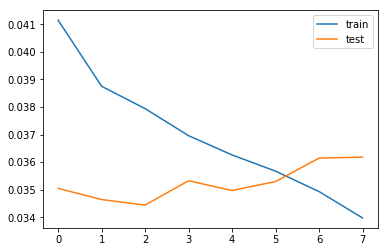

In [206]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show();

In [44]:
predictions = model.predict(scaled_test)

In [48]:
sqrt(mean_squared_error(y_test, predictions))

195.60102523397694

In [276]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, X_test), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)


The shape of the data must be the same when inverting the scale as when it was originally scaled.

This means, if you scaled with the entire test dataset (all columns), then you need to tack the yhat onto 
the test dataset for the inverse. We jump through these exact hoops at the end of the example when calculating RMSE.

In [258]:
X_test.shape

(35135, 1, 9)

In [259]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [264]:
X_test.shape

(35135, 9)

In [261]:
X_test[:, 1:].shape

(35135, 8)

In [265]:
test.shape

(35135, 10)

In [267]:
inv_yhat = concatenate((yhat, X_test), axis=1)

In [268]:
inv_yhat.shape

(35135, 10)

In [266]:
scaled_test.shape

(35135, 10)

In [278]:
inv_yhat[:,0]

array([1.1611485, 1.148819 , 1.1445361, ..., 1.3827499, 1.3699251,
       1.3691324], dtype=float32)